In [4]:
!pip install adlfs
!pip install keras-tuner --quiet


#### IMPORTS

In [5]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
import plotly.express as px
import joblib
from datetime import timedelta
from typing import List, Tuple, Dict,Optional

# Azure
from adlfs import AzureBlobFileSystem

from typing import Tuple, List, Optional
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd


# Models
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc ,  precision_score, recall_score
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.utils import class_weight

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU,Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, Precision, Recall
from keras_tuner import RandomSearch


#### FUNCTIONS

In [6]:

def load_data_from_dl(account_name: str,container_name: str,relative_path: str,access_key: str)->pd.DataFrame:
    """
    Loads all Parquet files from an Azure Blob Storage path into a single DataFrame.
    Args:
        - account_name (str): Azure Storage account name.
        - container_name (str): Name of the container.
        - relative_path (str): Path inside the container to search for .parquet files.
        - access_key (str): Storage account access key.
    Returns:
        - df (pd.DataFrame): Combined DataFrame from all found Parquet files.
    Raises:
        - ValueError: If no Parquet files are found in the path.
    """
    abfs = AzureBlobFileSystem(account_name=account_name, account_key=access_key)


    all_files = abfs.glob(f"{container_name}/{relative_path}/*.parquet")
    print(f"folder: {all_files}")

    if not all_files:
        raise ValueError("Not found .parquet files")

    dfs = []
    for f in all_files:
        print(f"Reading files: {f}")
        with abfs.open(f, "rb") as fp:
            dfs.append(pd.read_parquet(fp))

    df = pd.concat(dfs, ignore_index=True)
    print(df.head())
    return df

In [7]:
def model_evaluation(
    y_test: pd.Series,
    y_pred: pd.Series,
    y_prob: pd.Series
) -> Tuple[float, float, float, np.ndarray, float, float]:
    """
    Evaluates the classification model and plots metrics.

    Args:
        y_test (pd.Series): True target values.
        y_pred (pd.Series): Predicted class values.
        y_prob (pd.Series): Predicted probabilities for class 1.

    Returns:
        Tuple containing Accuracy, F1 Score, ROC AUC, Confusion Matrix, Precision, Recall.
    """
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    fig, ax = plt.subplots(figsize=(5, 4))
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_yticklabels(['No', 'Yes'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, f1, roc, cm, precision, recall


In [8]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
  """
  Cleans a DataFrame by dropping unnecessary columns and handling missing values.

  Args:
      df (pd.DataFrame): Input DataFrame.

  Returns:
      pd.DataFrame: Cleaned DataFrame.
  """
  columns_to_drop = [
      'capital_gains',
      'ret_next_3m', 'ret_next_6m', 'ret_next_1y',
      'price_lead_3m', 'price_lead_6m', 'price_lead_1y',
      'open_v', 'high', 'low', 'dividends', 'stock_splits',
      'is_dividend_day', 'is_stock_split', 'gap_open', 'price_range',
      'tr_1', 'tr_2', 'tr_3', 'sma_5', 'bollinger_upper',
      'bollinger_lower', 'ema_12', 'macd_line'
  ]


  print(f"Shape before: {df.shape}")
  df = df.drop(columns=columns_to_drop, errors='ignore').copy()
  numeric_cols = df.select_dtypes(include=["float64", "int64", "int32"]).columns
  imputer = SimpleImputer(strategy="mean")
  df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
  print(f"Shape after: {df.shape}")
  return df;

In [9]:
def prepare_data(
    df: pd.DataFrame,
    targets: list
):
    """
    Prepares a DataFrame for LSTM modeling: imputes missing values and applies MinMax scaling.

    Args:
        df (pd.DataFrame): Input data with features + target + symbol + date.
        targets (list): List of target column names.

    Returns:
        pd.DataFrame: Scaled dataframe with symbol and date preserved.
        MinMaxScaler: The fitted scaler object.
    """
    df_clean = df.copy()

    # Separar columnas a preservar
    symbol_col = df_clean["symbol"]
    date_col = df_clean["date"]

    # Eliminar columnas no necesarias para el modelo
    df_clean = df_clean.drop(columns=["symbol", "date"], errors="ignore")

    # Codificación de categóricas si existieran (seguridad)
    for col in df_clean.select_dtypes(include=["object", "category"]).columns:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))

    # Separar features y targets
    feature_cols = [col for col in df_clean.columns if col not in targets]
    X = df_clean[feature_cols]
    y = df_clean[targets]

    # Imputación + escalado
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    df_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df_clean.index)
    df_scaled = pd.concat([df_scaled, y], axis=1)

    # Reincorporar columnas para split posterior
    df_scaled["symbol"] = symbol_col.values
    df_scaled["date"] = date_col.values

    return df_scaled, scaler


In [10]:
def split_by_symbol (df, target_column, test_size=0.2):
    train_rows, test_rows = [], []

    for symbol in df["symbol"].unique():
        df_symbol = df[df["symbol"] == symbol].copy()
        df_symbol = df_symbol.sort_values("date")

        split_idx = int(len(df_symbol) * (1 - test_size))
        train_rows.append(df_symbol.iloc[:split_idx])
        test_rows.append(df_symbol.iloc[split_idx:])

    df_train = pd.concat(train_rows)
    df_test = pd.concat(test_rows)

    X_train = df_train.drop(columns=[target_column])
    y_train = df_train[target_column]

    X_test = df_test.drop(columns=[target_column])
    y_test = df_test[target_column]

    return X_train, X_test, y_train, y_test


In [11]:
def build_and_split_sequences_by_symbol(
    df: pd.DataFrame,
    target_column: str,
    sequence_length: int = 60,
    test_size: float = 0.2
):
    """
    Builds sequential data for each symbol independently and performs temporal train-test split.

    Args:
        df (pd.DataFrame): Preprocessed DataFrame with features and target.
        target_column (str): Column name for binary target.
        sequence_length (int): Time window for each sequence.
        test_size (float): Proportion of test samples (applied per symbol).

    Returns:
        Tuple of numpy arrays: X_train, X_test, y_train, y_test
    """
    X_train, y_train, X_test, y_test = [], [], [], []

    symbols = df["symbol"].unique()
    for symbol in symbols:
        df_symbol = df[df["symbol"] == symbol].copy()
        df_symbol = df_symbol.sort_values("date")

        if len(df_symbol) <= sequence_length:
            continue  # skip if not enough data

        df_symbol[target_column] = df_symbol[target_column].astype(int)
        features = df_symbol.drop(columns=["date", "symbol", "target_3m", "target_6m", "target_1y"], errors="ignore")
        target = df_symbol[target_column].values
        #features.to_csv(f"{symbol}.csv",sep=";")
        #sys.exit(0)

        split_idx = int(len(features) * (1 - test_size))
        for i in range(len(features) - sequence_length):
            if i + sequence_length >= len(features):
                continue  # avoid index error

            X_seq = features.iloc[i:i + sequence_length].values.astype(np.float32)
            y_val = target[i + sequence_length]

            if i + sequence_length < split_idx:
                X_train.append(X_seq)
                y_train.append(y_val)
            else:
                X_test.append(X_seq)
                y_test.append(y_val)

    return (
        np.array(X_train),
        np.array(X_test),
        np.array(y_train),
        np.array(y_test)
    )


In [12]:
def train_base_lstm_classifier(
    X_train,
    X_test,
    y_train,
    y_test,
    sequence_length=60,
    epochs=30,
    batch_size=32,
    patience=4,
    class_weight=None
):
    """
    Trains a simple LSTM classifier with basic architecture and early stopping.

    Args:
        X_train (np.ndarray): Training sequences.
        X_test (np.ndarray): Test sequences.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Test labels.
        sequence_length (int): Length of each input sequence.
        epochs (int): Maximum number of epochs.
        batch_size (int): Batch size.
        patience (int): Early stopping patience.
        class_weight (dict, optional): Class weights to handle imbalance.

    Returns:
        model (Sequential): Trained Keras model.
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): Test labels.
        y_prob (np.ndarray): Predicted probabilities.
        y_pred (np.ndarray): Predicted binary classes.
    """
    model = Sequential([
        LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', AUC(name='auc')]
    )

    early_stop = EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=patience,
        restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1,
        class_weight=class_weight
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    return model, X_test, y_test, y_prob, y_pred


In [13]:
def train_improved_lstm_classifier(
    X_train,
    X_test,
    y_train,
    y_test,
    sequence_length=120,
    epochs=30,
    batch_size=32,
    patience=6,
    learning_rate=1e-4,
    threshold=0.5,
    class_weight=None
):
    """
    Trains a bidirectional LSTM classifier with dropout, batch normalization, and threshold tuning.

    Args:
        X_train, X_test: Input sequences
        y_train, y_test: Labels
        sequence_length (int): Number of timesteps per sequence
        epochs (int): Max epochs
        batch_size (int): Training batch size
        patience (int): Early stopping patience
        learning_rate (float): Optimizer learning rate
        threshold (float): Threshold to binarize output
        class_weight (dict): Optional class weights

    Returns:
        model: Trained Keras model
        X_test, y_test: Evaluation inputs
        y_prob: Predicted probabilities
        y_pred: Binary predictions based on threshold
    """
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        BatchNormalization(),
        Dropout(0.4),
        Bidirectional(LSTM(32, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )

    early_stop = EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=patience,
        restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1,
        class_weight=class_weight
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > threshold).astype(int)

    return model, X_test, y_test, y_prob, y_pred


# **MAIN**

In [14]:
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

account_name = config['storage']['storage_account_name']
container_name = config['storage']['container_name']
relative_path = config['storage']['relative_path']
access_key = config['storage']['access_key']'''

# Cargar el DataFrame desde Azure
df_full = load_data_from_dl(account_name, container_name, relative_path, access_key)
df_full = df_full.dropna(subset=['ret_next_3m', 'ret_next_6m', 'ret_next_1y'])


folder: ['smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet']
Reading files: smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet
         date  symbol      open_v        high         low     close_v  \
0  2023-07-25  TEL.OL   99.110617   99.423126   98.128441   98.128441   
1  2023-07-25    ACIW   23.270000   23.530001   23.129999   23.420000   
2  2023-07-25     TER  114.730270  117.172184  114.730270  116.368141   
3  2023-07-25    ADCT    1.320000    1.330000    1.218000    1.290000   
4  2023-07-25     TEX   59.353587   59.490459   57.574251   57.769783   

      volume  dividends  stock_splits  capital_gains  ...  candle_color  \
0  1170518.0        0.0           0.0            NaN  ...           red   
1   301500.0        0.0           0.0            NaN  ...         green   
2  1256700.0       

In [15]:
df_full.to_parquet("df_full_spark.parquet")


In [13]:
#df_full=pd.read_parquet("df_full_spark.parquet")

In [17]:

#Addtargets
df_full["target_3m"] = (df_full["ret_next_3m"] > 0.1).astype(int)
df_full["target_6m"] = (df_full["ret_next_6m"] > 0.1).astype(int)
df_full["target_1y"] = (df_full["ret_next_1y"] > 0.1).astype(int)
print(f" target_3m: {df_full['target_3m'].value_counts()}")
print(f" target_6m: {df_full['target_6m'].value_counts()}")
print(f" target_1y: {df_full['target_1y'].value_counts()}")


 target_3m: target_3m
0    7475299
1    3371248
Name: count, dtype: int64
 target_6m: target_6m
0    6463478
1    4383069
Name: count, dtype: int64
 target_1y: target_1y
0    5554342
1    5292205
Name: count, dtype: int64


 target_3m: target_3m
0    227663
1     84902
Name: count, dtype: int64
 target_6m: target_6m
0    193544
1    119021
Name: count, dtype: int64
 target_1y: target_1y
0    161096
1    151469
Name: count, dtype: int64
Shape before: (312565, 56)
Shape after: (312565, 32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.5042 - auc: 0.5378 - loss: 0.6896 - val_accuracy: 0.5081 - val_auc: 0.5303 - val_loss: 0.6918
Epoch 2/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.5025 - auc: 0.5524 - loss: 0.6876 - val_accuracy: 0.4898 - val_auc: 0.5452 - val_loss: 0.7044
Epoch 3/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.5096 - auc: 0.5573 - loss: 0.6862 - val_accuracy: 0.4866 - val_auc: 0.5448 - val_loss: 0.6984
Epoch 4/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.5095 - auc: 0.5633 - loss: 0.6848 - val_accuracy: 0.4988 - val_auc: 0.5293 - val_loss: 0.6934
Epoch 5/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.5185 - auc: 0.5680 - loss: 0.6835 - val_accuracy: 0.5249 - val_auc: 0.5174 - val_loss: 0.7001
Epoch 6/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.5228 - auc: 0.5737 - loss: 0.6822 - val_accuracy: 0.4660 - val_auc: 0.4951 - val_loss: 0.7105
1955/1955 ━━━━━━━━━━━━

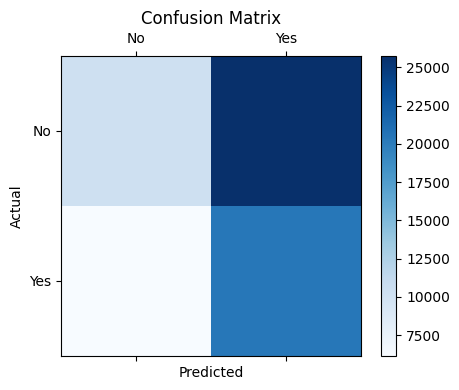

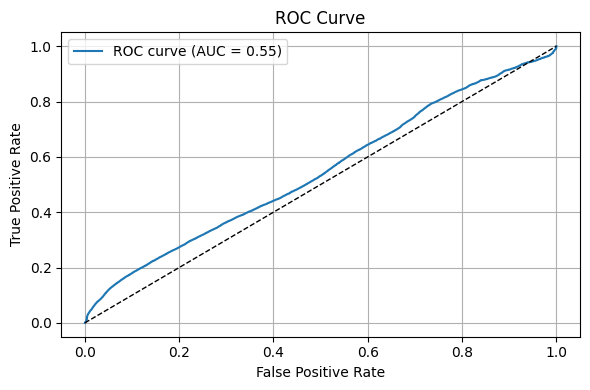

(0.4897580632265699,
 0.5605970889161239,
 np.float64(0.545381437074604),
 array([[10273, 25747],
        [ 6162, 20355]]),
 0.4415209752288404,
 0.7676207715804956)

In [ ]:
# Selección de top 50 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(50)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean.to_csv("1_df_clean_ordenado.csv",sep=";")

print(f" target_3m: {df_clean['target_3m'].value_counts()}")
print(f" target_6m: {df_clean['target_6m'].value_counts()}")
print(f" target_1y: {df_clean['target_1y'].value_counts()}")


# Limpieza con imputación
df_clean = clean_columns(df_clean)
df_clean.to_csv("2_df_cleean_limpio.csv",sep=";")

# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(
    df_clean,
    targets=targets
)
df_processed_minmax.to_csv("3_df_processed_minmax_escalado.csv", sep=";")



# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (312565, 56)
Shape after: (312565, 32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 173s 21ms/step - accuracy: 0.5211 - auc: 0.5116 - loss: 0.7918 - precision: 0.3773 - recall: 0.4551 - val_accuracy: 0.5248 - val_auc: 0.5633 - val_loss: 0.6873 - val_precision: 0.4562 - val_recall: 0.6277
Epoch 2/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 164s 21ms/step - accuracy: 0.5128 - auc: 0.5292 - loss: 0.6996 - precision: 0.3883 - recall: 0.5453 - val_accuracy: 0.4953 - val_auc: 0.5550 - val_loss: 0.6981 - val_precision: 0.4434 - val_recall: 0.7453
Epoch 3/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 159s 21ms/step - accuracy: 0.5252 - auc: 0.5520 - loss: 0.6889 - precision: 0.4000 - recall: 0.5753 - val_accuracy: 0.5757 - val_auc: 0.5734 - val_loss: 0.6796 - val_precision: 0.4996 - val_recall: 0.4525
Epoch 4/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 156s 20ms/step - accuracy: 0.5327 - auc: 0.5695 - loss: 0.6855 - precision: 0.4115 - recall: 0.6106 - val_accuracy: 0.4645 - val_auc: 0.5413 - val_loss: 0.6997 - val_precision: 0.4292 - val_recall: 0.7965
Epoch 5/30
7

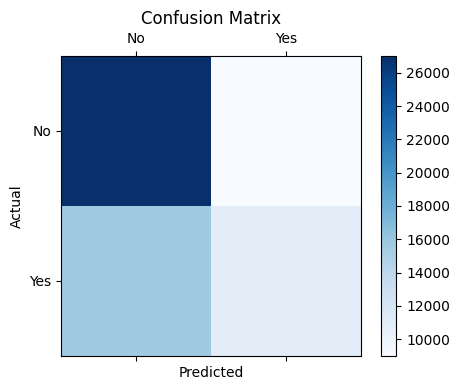

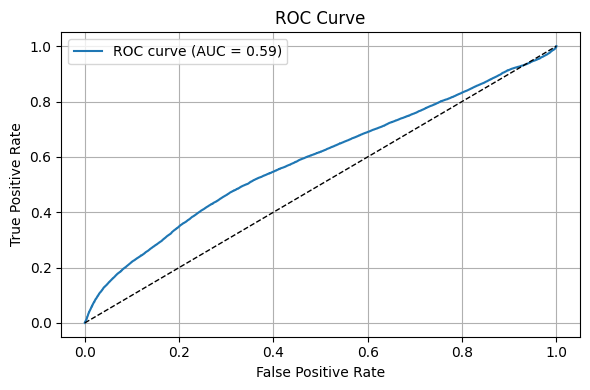

(0.6053536306506548,
 0.46794291381020137,
 np.float64(0.590943910517044),
 array([[27004,  9016],
        [15664, 10853]]),
 0.5462277920378479,
 0.4092846098729117)

In [ ]:
# Selección de top 50 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(50)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

# Limpieza con imputación
df_clean = clean_columns(df_clean)
df_clean.to_csv("2_df_cleean_limpio.csv",sep=";")

# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(
    df_clean,
    targets=targets
)


# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (312565, 56)
Shape after: (312565, 32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
7626/7626 ━━━━━━━━━━━━━━━━━━━━ 238s 30ms/step - accuracy: 0.5054 - auc: 0.5144 - loss: 0.7696 - precision: 0.3796 - recall: 0.5264 - val_accuracy: 0.4990 - val_auc: 0.5550 - val_loss: 0.6976 - val_precision: 0.4451 - val_recall: 0.7356
Epoch 2/30
7626/7626 ━━━━━━━━━━━━━━━━━━━━ 231s 30ms/step - accuracy: 0.5181 - auc: 0.5373 - loss: 0.6965 - precision: 0.3920 - recall: 0.5514 - val_accuracy: 0.6066 - val_auc: 0.5803 - val_loss: 0.6718 - val_precision: 0.6296 - val_recall: 0.1754
Epoch 3/30
7626/7626 ━━━━━━━━━━━━━━━━━━━━ 230s 30ms/step - accuracy: 0.5310 - auc: 0.5575 - loss: 0.6873 - precision: 0.4036 - recall: 0.5782 - val_accuracy: 0.4692 - val_auc: 0.5608 - val_loss: 0.6971 - val_precision: 0.4347 - val_recall: 0.8379
Epoch 4/30
7626/7626 ━━━━━━━━━━━━━━━━━━━━ 229s 30ms/step - accuracy: 0.5311 - auc: 0.5752 - loss: 0.6835 - precision: 0.4127 - recall: 0.6299 - val_accuracy: 0.5947 - val_auc: 0.5783 - val_loss: 0.6801 - val_precision: 0.5313 - val_recall: 0.3737
Epoch 5/30
7

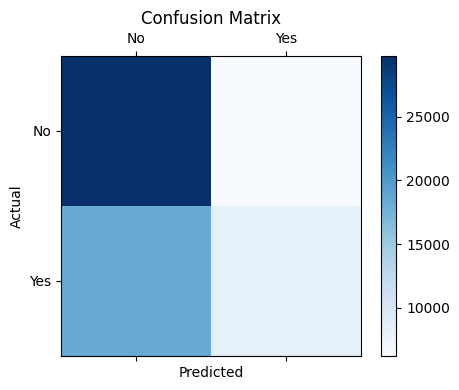

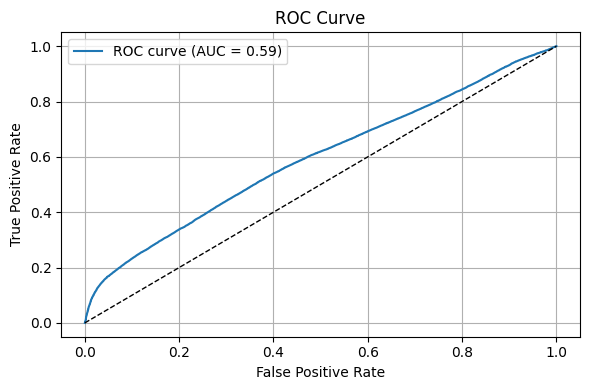

(0.6075603242880215,
 0.4012686020980727,
 np.float64(0.5943450370967744),
 array([[29771,  6249],
        [18293,  8224]]),
 0.5682304981690044,
 0.3101406644793906)

In [ ]:
# Selección de top 50 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(50)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])


# Limpieza con imputación
df_clean = clean_columns(df_clean)

# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(
    df_clean,
    targets=targets
)


# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 120
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


#Modificando la probabilidad a 0.4 para aumenta recall train_improved_lstm_classifier

Shape before: (312565, 56)
Shape after: (312565, 32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 162s 20ms/step - accuracy: 0.5064 - auc: 0.5134 - loss: 0.7709 - precision: 0.3780 - recall: 0.5237 - val_accuracy: 0.5013 - val_auc: 0.5554 - val_loss: 0.7014 - val_precision: 0.4465 - val_recall: 0.7343
Epoch 2/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 155s 20ms/step - accuracy: 0.5188 - auc: 0.5358 - loss: 0.6968 - precision: 0.3924 - recall: 0.5459 - val_accuracy: 0.5653 - val_auc: 0.5571 - val_loss: 0.6835 - val_precision: 0.4833 - val_recall: 0.3647
Epoch 3/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 156s 20ms/step - accuracy: 0.5297 - auc: 0.5530 - loss: 0.6889 - precision: 0.4027 - recall: 0.5662 - val_accuracy: 0.4860 - val_auc: 0.5228 - val_loss: 0.7026 - val_precision: 0.4403 - val_recall: 0.7826
Epoch 4/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 157s 20ms/step - accuracy: 0.5384 - auc: 0.5781 - loss: 0.6827 - precision: 0.4158 - recall: 0.6271 - val_accuracy: 0.4724 - val_auc: 0.5094 - val_loss: 0.7085 - val_precision: 0.4345 - val_recall: 0.8100
Epoch 5/30
7

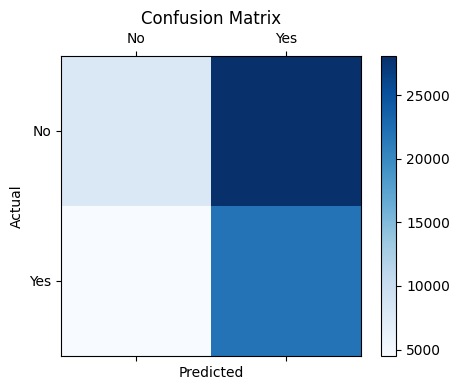

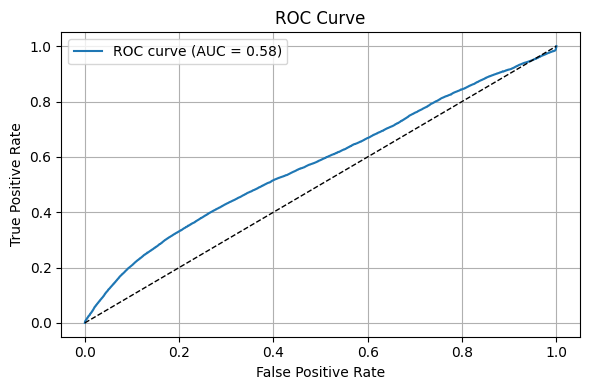

(0.4785806802372995,
 0.5742858634915662,
 np.float64(0.5772807626766917),
 array([[ 7935, 28085],
        [ 4523, 21994]]),
 0.43918608598414505,
 0.8294301768676698)

In [ ]:
# Selección de top 50 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(50)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])


# Limpieza con imputación
df_clean = clean_columns(df_clean)

# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(
    df_clean,
    targets=targets
)

# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    epochs=30,
    batch_size=32,
    patience=6,
    learning_rate=1e-4,
    threshold=0.4,
    class_weight=weight_dict
)


# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (312565, 56)
Shape after: (312565, 32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
7626/7626 ━━━━━━━━━━━━━━━━━━━━ 236s 30ms/step - accuracy: 0.5067 - auc: 0.5116 - loss: 0.7767 - precision: 0.3757 - recall: 0.5089 - val_accuracy: 0.5712 - val_auc: 0.5739 - val_loss: 0.6868 - val_precision: 0.4944 - val_recall: 0.4962
Epoch 2/30
7626/7626 ━━━━━━━━━━━━━━━━━━━━ 230s 30ms/step - accuracy: 0.5118 - auc: 0.5290 - loss: 0.6985 - precision: 0.3884 - recall: 0.5512 - val_accuracy: 0.4908 - val_auc: 0.5755 - val_loss: 0.6952 - val_precision: 0.4424 - val_recall: 0.7718
Epoch 3/30
7626/7626 ━━━━━━━━━━━━━━━━━━━━ 230s 30ms/step - accuracy: 0.5287 - auc: 0.5600 - loss: 0.6870 - precision: 0.4042 - recall: 0.5914 - val_accuracy: 0.6030 - val_auc: 0.5908 - val_loss: 0.6715 - val_precision: 0.5466 - val_recall: 0.3746
Epoch 4/30
7626/7626 ━━━━━━━━━━━━━━━━━━━━ 231s 30ms/step - accuracy: 0.5378 - auc: 0.5765 - loss: 0.6825 - precision: 0.4133 - recall: 0.6069 - val_accuracy: 0.5037 - val_auc: 0.5308 - val_loss: 0.7018 - val_precision: 0.4408 - val_recall: 0.6346
Epoch 5/30
7

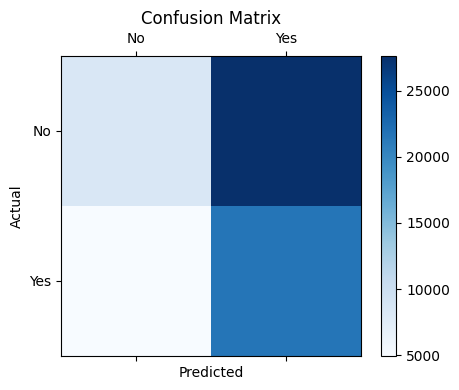

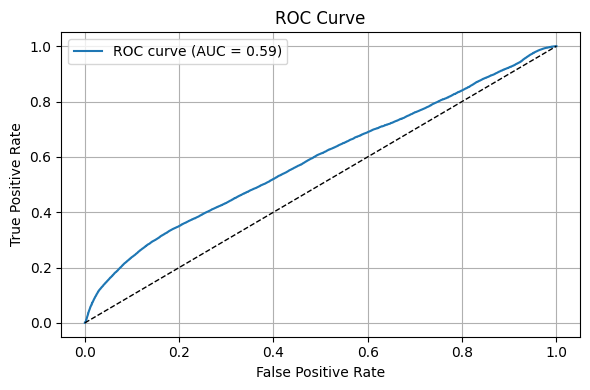

(0.4788525193085693,
 0.5692269056399276,
 np.float64(0.5908532701000356),
 array([[ 8413, 27607],
        [ 4984, 21533]]),
 0.4381969881969882,
 0.812045103141381)

In [ ]:
# Selección de top 50 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(50)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])


# Limpieza con imputación
df_clean = clean_columns(df_clean)

# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(
    df_clean,
    targets=targets
)

# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 120
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    epochs=30,
    batch_size=32,
    patience=6,
    learning_rate=1e-4,
    threshold=0.4,
    class_weight=weight_dict
)


# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


#Modificando los targets a  0.05 y 0.01

Shape before: (312565, 56)
Shape after: (312565, 32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 163s 20ms/step - accuracy: 0.5049 - auc: 0.5091 - loss: 0.7706 - precision: 0.4864 - recall: 0.5290 - val_accuracy: 0.5137 - val_auc: 0.5047 - val_loss: 0.7021 - val_precision: 0.5290 - val_recall: 0.5878
Epoch 2/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 160s 21ms/step - accuracy: 0.5172 - auc: 0.5261 - loss: 0.6973 - precision: 0.4967 - recall: 0.5278 - val_accuracy: 0.5043 - val_auc: 0.5234 - val_loss: 0.6995 - val_precision: 0.5342 - val_recall: 0.3626
Epoch 3/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 161s 21ms/step - accuracy: 0.5388 - auc: 0.5554 - loss: 0.6889 - precision: 0.5187 - recall: 0.5398 - val_accuracy: 0.4977 - val_auc: 0.5327 - val_loss: 0.7030 - val_precision: 0.5692 - val_recall: 0.1393
Epoch 4/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 162s 21ms/step - accuracy: 0.5498 - auc: 0.5716 - loss: 0.6853 - precision: 0.5297 - recall: 0.5742 - val_accuracy: 0.4789 - val_auc: 0.5034 - val_loss: 0.7092 - val_precision: 0.4982 - val_recall: 0.3239
Epoch 5/30
7

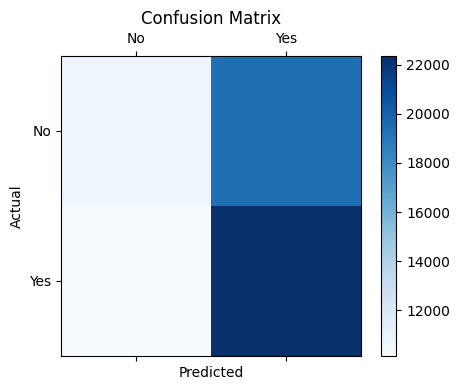

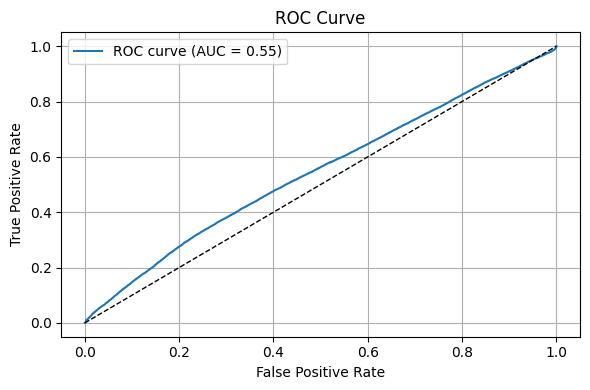

(0.5278475142715512,
 0.6022067441766473,
 np.float64(0.5460949658789046),
 array([[10660, 19366],
        [10161, 22350]]),
 0.5357656534662959,
 0.6874596290486297)

In [ ]:

#Addtargets
df_full["target_3m"] = (df_full["ret_next_3m"] > 0.05).astype(int)
df_full["target_6m"] = (df_full["ret_next_6m"] > 0.05).astype(int)
df_full["target_1y"] = (df_full["ret_next_1y"] > 0.05).astype(int)

# Selección de top 50 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(50)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])


# Limpieza con imputación
df_clean = clean_columns(df_clean)

# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(
    df_clean,
    targets=targets
)

# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    epochs=30,
    batch_size=32,
    patience=6,
    learning_rate=1e-4,
    threshold=0.5,
    class_weight=weight_dict
)


# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (312565, 56)
Shape after: (312565, 32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 163s 20ms/step - accuracy: 0.5183 - auc: 0.5179 - loss: 0.7649 - precision: 0.5842 - recall: 0.5429 - val_accuracy: 0.4246 - val_auc: 0.4986 - val_loss: 0.7148 - val_precision: 0.5716 - val_recall: 0.1636
Epoch 2/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 157s 20ms/step - accuracy: 0.5374 - auc: 0.5535 - loss: 0.6922 - precision: 0.6086 - recall: 0.5275 - val_accuracy: 0.5077 - val_auc: 0.4457 - val_loss: 0.7031 - val_precision: 0.5730 - val_recall: 0.7047
Epoch 3/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 157s 20ms/step - accuracy: 0.5536 - auc: 0.5766 - loss: 0.6845 - precision: 0.6255 - recall: 0.5405 - val_accuracy: 0.4365 - val_auc: 0.4835 - val_loss: 0.7212 - val_precision: 0.5527 - val_recall: 0.3185
Epoch 4/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 157s 20ms/step - accuracy: 0.5598 - auc: 0.5874 - loss: 0.6812 - precision: 0.6331 - recall: 0.5429 - val_accuracy: 0.5134 - val_auc: 0.4504 - val_loss: 0.7086 - val_precision: 0.5788 - val_recall: 0.6943
Epoch 5/30
7

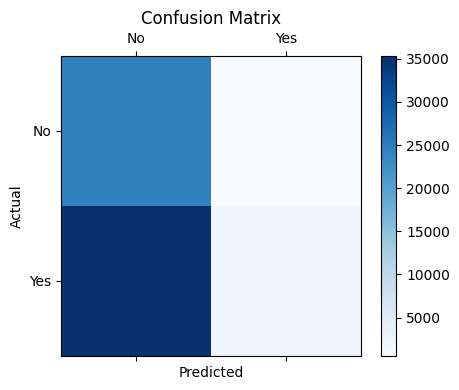

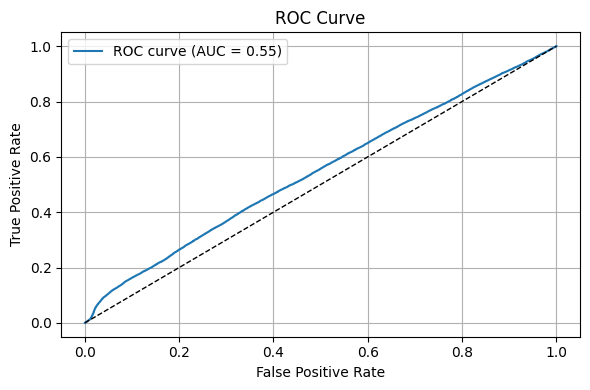

(0.4257639477429362,
 0.1092839248952055,
 np.float64(0.5462813011033094),
 array([[24423,   594],
        [35317,  2203]]),
 0.7876296031462281,
 0.058715351812366735)

In [ ]:

#Addtargets
df_full["target_3m"] = (df_full["ret_next_3m"] > 0.01).astype(int)
df_full["target_6m"] = (df_full["ret_next_6m"] > 0.01).astype(int)
df_full["target_1y"] = (df_full["ret_next_1y"] > 0.01).astype(int)

# Selección de top 50 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(50)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])


# Limpieza con imputación
df_clean = clean_columns(df_clean)

# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(
    df_clean,
    targets=targets
)

# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    epochs=30,
    batch_size=32,
    patience=6,
    learning_rate=1e-4,
    threshold=0.5,
    class_weight=weight_dict
)


# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


**TUNER**

In [ ]:
from keras_tuner import RandomSearch
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall

def train_lstm_with_tuner(
    X_train,
    X_test,
    y_train,
    y_test,
    class_weight=None,
    max_trials=10,
    executions_per_trial=1,
    epochs=10,
    batch_size=32,
    patience=4,
    threshold=0.5
):
    def build_model(hp):
        model = models.Sequential()
        model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))

        model.add(layers.Bidirectional(layers.LSTM(
            units=hp.Int("lstm_units1", 32, 128, step=32),
            return_sequences=True
        )))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float("dropout1", 0.2, 0.5, step=0.1)))

        model.add(layers.Bidirectional(layers.LSTM(
            units=hp.Int("lstm_units2", 16, 64, step=16),
            return_sequences=False
        )))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float("dropout2", 0.2, 0.5, step=0.1)))

        model.add(layers.Dense(
            hp.Int("dense_units", 32, 128, step=32),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float("dropout3", 0.2, 0.5, step=0.1)))

        model.add(layers.Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=Adam(learning_rate=hp.Choice("lr", [1e-3, 1e-4])),
            loss=BinaryCrossentropy(),
            metrics=["accuracy", AUC(name='auc'), Precision(), Recall()]
        )
        return model

    tuner = RandomSearch(
        build_model,
        objective="val_auc",
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory="tuner_dir",
        project_name="lstm_opt"
    )

    early_stop = EarlyStopping(monitor="val_auc", patience=patience, mode="max", restore_best_weights=True)

    tuner.search(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        class_weight=class_weight,
        verbose=2
    )

    tuner.results_summary()
    best_hp = tuner.get_best_hyperparameters(1)[0]

    print("\n🔧 Mejor configuración encontrada:")
    for k in best_hp.values:
        print(f"{k}: {best_hp.get(k)}")

    best_model = tuner.get_best_models(1)[0]
    y_prob = best_model.predict(X_test).flatten()
    y_pred = (y_prob > threshold).astype(int)

    return best_model, X_test, y_test, y_prob, y_pred


In [ ]:
df_full["target_3m"] = (df_full["ret_next_3m"] > 0.05).astype(int)
df_full["target_6m"] = (df_full["ret_next_6m"] > 0.05).astype(int)
df_full["target_1y"] = (df_full["ret_next_1y"] > 0.05).astype(int)
# Selección de top 100 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(100)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
#df_clean.to_csv("1_df_clean_ordenado.csv",sep=";")


# Limpieza con imputación
df_clean = clean_columns(df_clean)
#df_clean.to_csv("2_df_cleean_limpio.csv",sep=";")

# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(
    df_clean,
    targets=targets
)
#df_processed_minmax.to_csv("3_df_processed_minmax_escalado.csv", sep=";")



# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 90
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_lstm_with_tuner(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    class_weight=weight_dict,
    max_trials=10,
    executions_per_trial=1,
    epochs=10,
    batch_size=32,
    patience=4
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Trial 9 Complete [00h 35m 42s]
val_auc: 0.5479590892791748

Best val_auc So Far: 0.5930365324020386
Total elapsed time: 05h 57m 16s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
96                |128               |lstm_units1
0.2               |0.3               |dropout1
32                |16                |lstm_units2
0.4               |0.2               |dropout2
96                |128               |dense_units
0.2               |0.3               |dropout3
0.001             |0.0001            |lr

Epoch 1/10
15290/15290 - 365s - 24ms/step - accuracy: 0.5043 - auc: 0.5046 - loss: 0.6948 - precision: 0.4865 - recall: 0.4682 - val_accuracy: 0.4849 - val_auc: 0.5010 - val_loss: 0.6930 - val_precision: 0.4842 - val_recall: 0.9997
Epoch 2/10
15290/15290 - 358s - 23ms/step - accuracy: 0.5006 - auc: 0.5033 - loss: 0.6932 - precision: 0.4851 - recall: 0.5496 - val_accuracy: 0.5299 - val_auc: 0.5430 - val_loss: 0.7463 - val_precision: 0.5124 - val_recal

In [ ]:
def save_trained_model_and_scaler(model, scaler, model_name, target_column, folder_path='/content/drive/MyDrive/modelos_lstm'):
    """
    Save trained LSTM model and corresponding scaler.

    Args:
        model: Trained Keras model object.
        scaler: Fitted scaler (e.g., MinMaxScaler).
        model_name (str): Identifier name for model (e.g. "improved_lstm").
        target_column (str): Target variable name (e.g. "target_6m").
        folder_path (str): Directory path where to save model and scaler.
    """
    import os
    import joblib
    from tensorflow.keras.models import save_model

    os.makedirs(folder_path, exist_ok=True)

    model_path = f"{folder_path}/{model_name}.keras"
    scaler_path = f"{folder_path}/scaler_{model_name}.pkl"

    save_model(model, model_path)
    joblib.dump(scaler, scaler_path)

    print(f"Modelo guardado en: {model_path}")
    print(f"Scaler guardado en: {scaler_path}")




# Random forest para feature importance...

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


# 1. Definir target
df_full["target_3m"] = (df_full["ret_next_3m"] > 0.05).astype(int)
df_full["target_6m"] = (df_full["ret_next_6m"] > 0.05).astype(int)
df_full["target_1y"] = (df_full["ret_next_1y"] > 0.05).astype(int)


# 2. Selección top símbolos
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(500)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])


# Codificación de categóricas si existieran (seguridad)
for col in df_clean.select_dtypes(include=["object", "category"]).columns:
    df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))

# 3. Random Forest para obtener top features
df_rf = df_clean.drop(columns=["symbol", "date"], errors="ignore").copy()
targets = ['target_3m', 'target_6m', 'target_1y']
X_rf = df_rf.drop(columns=targets)
y_rf = df_rf["target_6m"]

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_rf, y_train_rf)
importances = pd.Series(rf.feature_importances_, index=X_rf.columns)
top_features = importances.sort_values(ascending=False).head(20).index.tolist()
print("Top 20 features seleccionadas:")
print(top_features)

In [ ]:
def prepare_data_custom(df, targets):
    symbol_col = df["symbol"]
    date_col = df["date"]
    df = df.drop(columns=["symbol", "date"], errors="ignore")

    for col in df.select_dtypes(include=["object", "category"]).columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    feature_cols = [col for col in df.columns if col not in targets]
    X = df[feature_cols]
    y = df[targets]

    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    df_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df.index)
    df_scaled = pd.concat([df_scaled, y], axis=1)
    df_scaled["symbol"] = symbol_col.values
    df_scaled["date"] = date_col.values
    return df_scaled, scaler

In [ ]:

# Selección de top 100 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(200)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
#df_clean.to_csv("1_df_clean_ordenado.csv",sep=";")


# Limpieza con imputación
#df_clean = clean_columns(df_clean)
top_features = [
    'close_v', 'low', 'high', 'open_v', 'sma_5', 'prev_close',
    'ema_12', 'ema_26', 'bollinger_upper', 'sma_20',
    'bollinger_lower', 'var_95', 'atr_14', 'volume'
]
df_clean = df_clean[top_features + ['target_3m', 'target_6m', 'target_1y', 'symbol', 'date']].copy()

# Preprocesado (sin imputar aquí)
df_processed_minmax, scaler_minmax = prepare_data_custom(df_clean, ['target_3m', 'target_6m', 'target_1y'])


# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 90
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax, target_column, sequence_length, test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


# INCLUYENDO SYMBOL Y DATE ...

In [ ]:
def prepare_data_with_symbol_date(df: pd.DataFrame, targets: list):
    """
    Prepares a DataFrame for LSTM modeling: encodes 'symbol', extracts 'date' features,
    imputes missing values, and applies MinMax scaling.

    Args:
        df (pd.DataFrame): Input data with features + target + symbol + date.
        targets (list): List of target column names.

    Returns:
        pd.DataFrame: Scaled dataframe with 'symbol' and 'date' incorporated as features.
        MinMaxScaler: The fitted scaler object.
    """
    df_clean = df.copy()

    # Convert date and extract features
    df_clean["date"] = pd.to_datetime(df_clean["date"], errors="coerce")
    df_clean["year"] = df_clean["date"].dt.year
    df_clean["month"] = df_clean["date"].dt.month
    df_clean["dayofweek"] = df_clean["date"].dt.dayofweek

    date_col = df_clean["date"]  # store datetime (not string)

    # Encode symbol (remains numeric)
    df_clean["symbol"] = LabelEncoder().fit_transform(df_clean["symbol"].astype(str))

    # Drop original date before scaling
    df_clean = df_clean.drop(columns=["date"], errors="ignore")

    for col in df_clean.select_dtypes(include=["object", "category"]).columns:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))

    feature_cols = [col for col in df_clean.columns if col not in targets]
    X = df_clean[feature_cols]
    y = df_clean[targets]

    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    df_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df_clean.index)
    df_scaled = pd.concat([df_scaled, y], axis=1)

    # Reattach encoded symbol and original date
    df_scaled["symbol"] = df_clean["symbol"].values
    df_scaled["date"] = date_col.values

    return df_scaled, scaler


In [ ]:
def build_and_split_sequences_by_symbol(
    df: pd.DataFrame,
    target_column: str,
    sequence_length: int = 60,
    test_size: float = 0.2
):
    """
    Builds sequential data for each symbol independently and performs temporal train-test split.

    Args:
        df (pd.DataFrame): Preprocessed DataFrame with features, target, 'symbol' and 'date'.
        target_column (str): Column name for binary target.
        sequence_length (int): Time window for each sequence.
        test_size (float): Proportion of test samples (applied per symbol).

    Returns:
        Tuple of numpy arrays: X_train, X_test, y_train, y_test
    """
    X_train, y_train, X_test, y_test = [], [], [], []

    symbols = df["symbol"].unique()
    for symbol in symbols:
        df_symbol = df[df["symbol"] == symbol].copy()
        df_symbol = df_symbol.sort_values("date")

        if len(df_symbol) <= sequence_length:
            continue  # Skip if not enough data

        df_symbol[target_column] = df_symbol[target_column].astype(int)
        features = df_symbol.drop(
            columns=["date", "target_3m", "target_6m", "target_1y"],
            errors="ignore"
        )
        target = df_symbol[target_column].values

        split_idx = int(len(features) * (1 - test_size))
        for i in range(len(features) - sequence_length):
            if i + sequence_length >= len(features):
                continue

            X_seq = features.iloc[i:i + sequence_length].values.astype(np.float32)
            y_val = target[i + sequence_length]

            if i + sequence_length < split_idx:
                X_train.append(X_seq)
                y_train.append(y_val)
            else:
                X_test.append(X_seq)
                y_test.append(y_val)

    return (
        np.array(X_train),
        np.array(X_test),
        np.array(y_train),
        np.array(y_test)
    )


Shape before: (312565, 56)
Shape after: (312565, 32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 165s 21ms/step - accuracy: 0.4997 - auc: 0.5051 - loss: 0.7532 - precision: 0.3715 - recall: 0.5157 - val_accuracy: 0.4756 - val_auc: 0.5122 - val_loss: 0.6981 - val_precision: 0.4191 - val_recall: 0.6130
Epoch 2/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 158s 20ms/step - accuracy: 0.5232 - auc: 0.5308 - loss: 0.6956 - precision: 0.3884 - recall: 0.5114 - val_accuracy: 0.4779 - val_auc: 0.5725 - val_loss: 0.6992 - val_precision: 0.4382 - val_recall: 0.8200
Epoch 3/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 160s 21ms/step - accuracy: 0.5346 - auc: 0.5660 - loss: 0.6864 - precision: 0.4101 - recall: 0.5861 - val_accuracy: 0.5308 - val_auc: 0.5585 - val_loss: 0.6892 - val_precision: 0.4565 - val_recall: 0.5601
Epoch 4/30
7720/7720 ━━━━━━━━━━━━━━━━━━━━ 157s 20ms/step - accuracy: 0.5530 - auc: 0.5950 - loss: 0.6783 - precision: 0.4275 - recall: 0.6190 - val_accuracy: 0.5650 - val_auc: 0.5443 - val_loss: 0.6860 - val_precision: 0.4803 - val_recall: 0.3153
Epoch 5/30
7

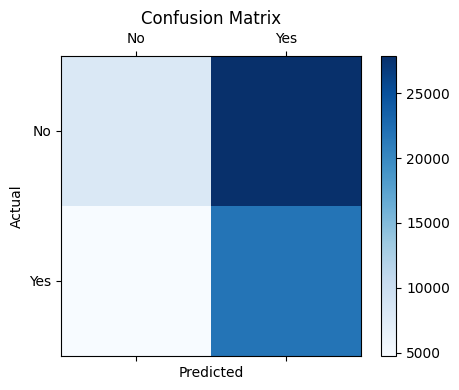

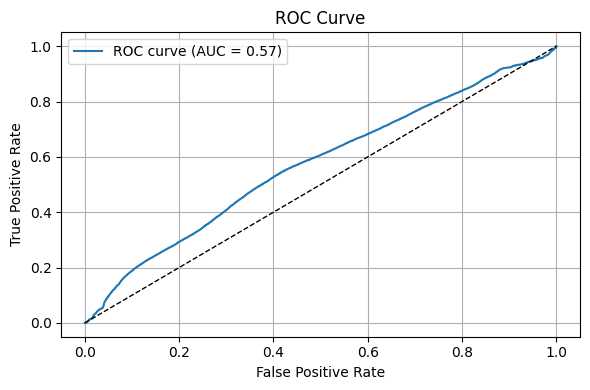

(0.47792506835953114,
 0.5711696328889473,
 np.float64(0.5727486983772492),
 array([[ 8145, 27875],
        [ 4774, 21743]]),
 0.4382079084203313,
 0.8199645510427273)

In [ ]:
df_full["target_3m"] = (df_full["ret_next_3m"] > 0.1).astype(int)
df_full["target_6m"] = (df_full["ret_next_6m"] > 0.1).astype(int)
df_full["target_1y"] = (df_full["ret_next_1y"] > 0.1).astype(int)
# Selección de top 50 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(50)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
#df_clean.to_csv("1_df_clean_ordenado.csv",sep=";")


# Limpieza con imputación
df_clean = clean_columns(df_clean)

# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data_with_symbol_date(
    df_clean,
    targets=targets
)


# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


# Almacenando un modelo

In [ ]:
def save_trained_model_and_scaler(model, scaler, model_name, target_column, folder_path='/content/drive/MyDrive/modelos_lstm'):
    """
    Save trained LSTM model and corresponding scaler.

    Args:
        model: Trained Keras model object.
        scaler: Fitted scaler (e.g., MinMaxScaler).
        model_name (str): Identifier name for model (e.g. "improved_lstm").
        target_column (str): Target variable name (e.g. "target_6m").
        folder_path (str): Directory path where to save model and scaler.
    """
    import os
    import joblib
    from tensorflow.keras.models import save_model

    os.makedirs(folder_path, exist_ok=True)

    model_path = f"{folder_path}/{model_name}.keras"
    scaler_path = f"{folder_path}/scaler_{model_name}.pkl"

    save_model(model, model_path)
    joblib.dump(scaler, scaler_path)

    print(f"Modelo guardado en: {model_path}")
    print(f"Scaler guardado en: {scaler_path}")


In [ ]:
#df_full=pd.read_parquet("df_full_spark.parquet")

In [ ]:
# Selección de top 50 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(200)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
df_clean.to_csv("1_df_clean_ordenado.csv",sep=";")

# Limpieza con imputación
df_clean = clean_columns(df_clean)
df_clean.to_csv("2_df_cleean_limpio.csv",sep=";")

# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(
    df_clean,
    targets=targets
)


# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


Shape before: (1238632, 56)
Shape after: (1238632, 32)


In [ ]:
save_trained_model_and_scaler(
    model=model,
    scaler=scaler_minmax,
    model_name="lstm_final_target_6m",
    target_column="target_6m"
)
